# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
!apt-get -y install protobuf-compiler
!git clone https://github.com/tensorflow/models.git
!cd models/research && protoc object_detection/protos/*.proto --python_out=.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 1,239 kB of archives.
After this operation, 4,935 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/main amd64 libprotobuf10 amd64 3.0.0-9ubuntu5 [650 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/main amd64 libprotoc10 amd64 3.0.0-9ubuntu5 [565 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/main amd64 protobuf-compiler amd64 3.0.0-9ubuntu5 [24.5 kB]
Fetched 1,239 kB in 0s (1,402 kB/s)
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../libprotobuf10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf1

Checking out files: 100% (2125/2125), done.


In [0]:
import numpy as np
import os
from io import BytesIO
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("./models/research/")
from object_detection.utils import ops as utils_ops
sys.path.append("./models/research/object_detection/")


In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

./models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87, in ca

In [0]:
%matplotlib inline

## Env setup

# Model preparation 

## Variables

Here we will download and extract the model inference graph, and the label inference map, so we can mark the appropriate labels.

In [0]:
# What model to download.
MODEL_NAME = 'faster_rcnn_resnet50_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
def analyze_api_results(image):
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)

In [0]:
IMAGE_SIZE = (12, 8)
def vis_detection (image):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

running detection model on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image2.jpg?raw=true...


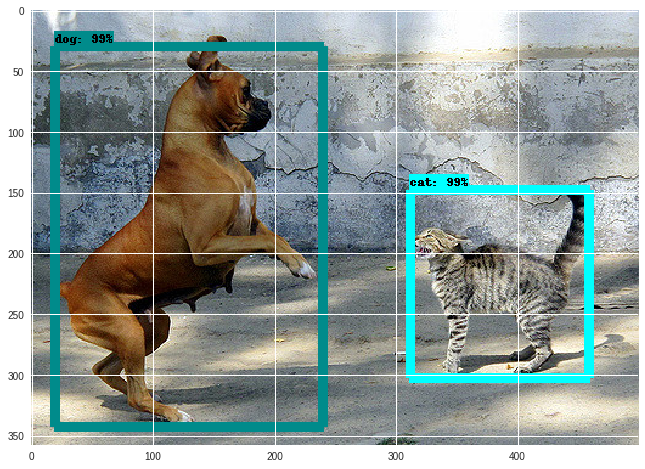

In [14]:
#@Test your images
#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image2'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences the model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    orignal_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running detection model on image %s...' % url)


  vis_detection(orignal_im)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)